# 1 - Setup

In [19]:
# givens
!pip install airfrans --quiet
!pip install pyvista --quiet
!sudo apt install libgl1-mesa-glx xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [20]:
import airfrans as af
import os
from pathlib import Path

In [21]:
# define current run params
project_folder = "airfrans"
dataset_folder = "Dataset"
tensor_folder = "data"

path_to_dataset = f"./{project_folder}/{dataset_folder}"

should_preprocess = False

# 2 - Download Processed Data





In [22]:
directory_name = Path(f'{project_folder}/')
directory_tensor = Path(f'{tensor_folder}/')

if not directory_name.exists() or not any(directory_name.iterdir()):
  af.dataset.download(root=str(directory_name), file_name=dataset_folder, unzip=True, OpenFOAM=should_preprocess)

if not directory_tensor.exists() or not any(directory_tensor.iterdir()):
    directory_tensor.mkdir(parents=True, exist_ok=True)

In [23]:
dataset_list, dataset_name = af.dataset.load(root=str(directory_name/dataset_folder), task = 'reynolds', train = True)

Loading dataset (task: reynolds, split: train): 100%|██████████| 504/504 [03:45<00:00,  2.23it/s]


# 3 - Understanding the Data

#### Other datasets
---
There are 3 datasets airfrans provides: a preprocessed set (used here), a raw dataset and a pytorch geometric dataset of the airfrans data. Considering this challenge instructs on downloading the preprocessed data, not the raw OpenFOAM data, that is the dataset that is used here.

#### Pytorch geometric
---
The pytorch geometric set is also not used to ensure data consistency with the given set. However, the data is still put into pytorch tensors since the model - likely a PINN judging from job announcements - is a pytorch model.

#### Data components
---
The data is a collection of 1000 simulations. Each folder contains 3 simulations, itself an object. We use internal because it contains sdf, a challenge requirement for input, and is the only one in 2D.


### Simulation data components

Each simulation contains variables representing turbulent viscosity, pressure, and velocity vector, sdf, and original ids (can be ignored) respectively.

In [24]:
example_simulation = "airFoil2D_SST_43.597_5.932_3.551_3.1_1.0_18.252"

In [25]:
import pyvista as pv

In [26]:
mesh = pv.read(f'/content/{project_folder}/{dataset_folder}/{example_simulation}/{example_simulation}_internal.vtu')

mesh.point_data.keys()

['nut', 'p', 'U', 'implicit_distance', 'vtkOriginalPointIds']

### Simulation Visualization

Any simulation object can be expanded for a visual of the aerofoil, like below.


In [27]:
import matplotlib.pyplot as plt
import airfrans as af

In [28]:
def visualize_airfoil(simulation: af.Simulation, figsize: tuple=(10, 12)):
    """
    Visualizes the velocity and sdf fields of an airfoil simulation.

    Parameters:
    simulation: The airfoil simulation object to visualize.
    figsize: Figure size for the plot, default is (10, 12).
    """

    fig, ax = plt.subplots(2, 1, figsize=figsize)

    # plot the sdf in the first subplot
    scatter1 = ax[0].scatter(
        simulation.position[:, 0],
        simulation.position[:, 1],
        c=simulation.sdf[:, 0],
        s=0.75
    )
    ax[0].set_title("Aerofoil SDF (input/train)")
    fig.colorbar(scatter1, ax=ax[0], label="SDF")

    # plot the velocity in the second subplot
    scatter2 = ax[1].scatter(
        simulation.position[:, 0],
        simulation.position[:, 1],
        c=simulation.velocity[:, 0],
        s=0.75
    )
    ax[1].set_title("Aerofoil Velocity (target/test)")
    fig.colorbar(scatter2, ax=ax[1], label="Velocity (v_x)")


    plt.tight_layout()
    plt.show()

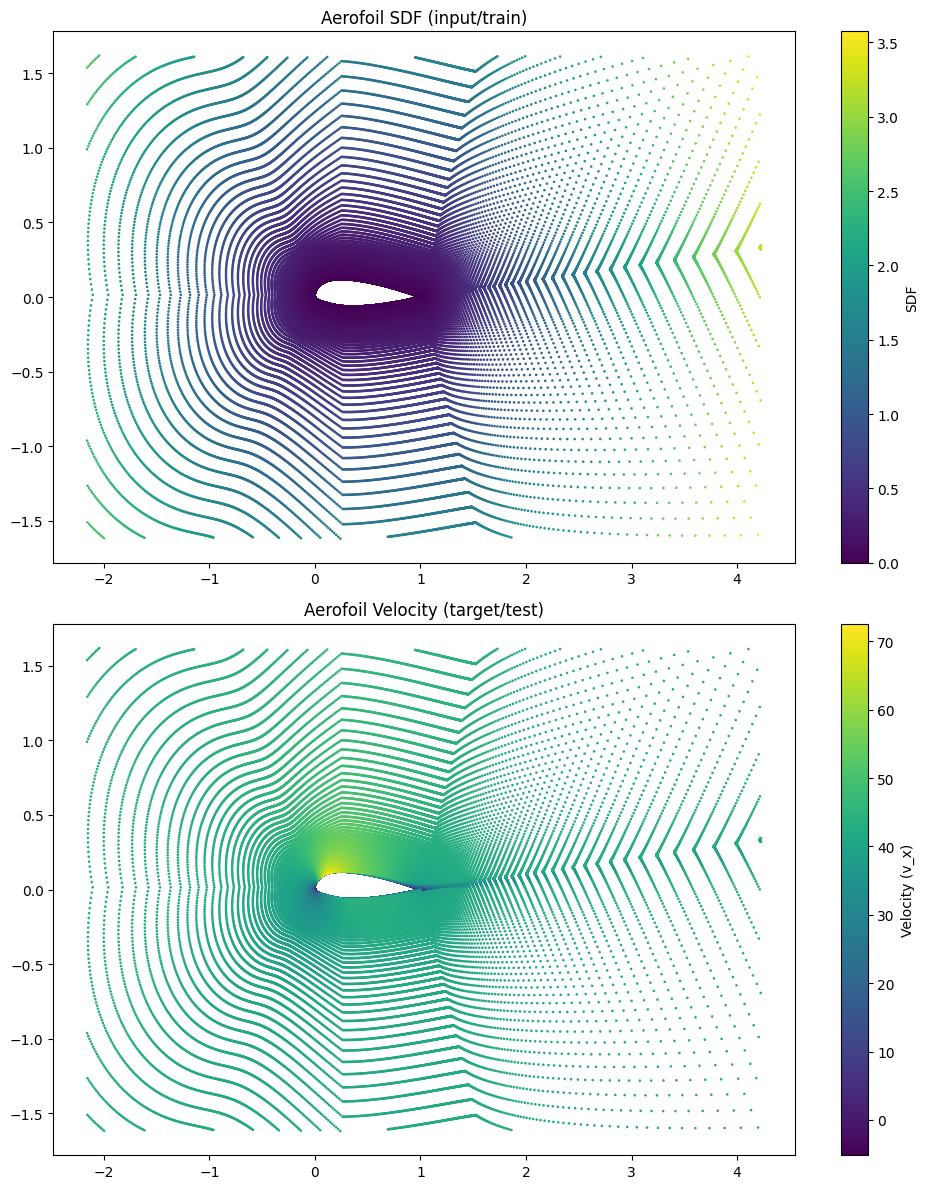

In [29]:
simulation = af.Simulation(root=path_to_dataset, name=example_simulation, T=298.15)
visualize_airfoil(simulation)

# 4 - Data Preparation

To best prepare the data for a pytorch model, and to transform the data for (x,y,sdf) input with (x_v, y_v) output, we convert between an airfrans simulation to a tensor.

Normalization is used to account for large ranges of all features of position, velocity, and sdf.

In [30]:
import torch, random
import airfrans as af
import numpy as np

### Simulation to Tensor Conversion

In [31]:
def simulation_to_tensor(simulation: af.Simulation) -> torch.Tensor:
    """
    Converts a single airfoil simulation to a normalized PyTorch tensor with
    features (x, y, sdf, v_x, v_y).

    No further feature selection or any feature engineering is applicable.

    See EDA script to find correlations that can be considered for engineering.

    Parameters:
    simulation: An airfrans simulation object.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 5) containing (x, y, sdf, v_x, v_y).
    """

    # extract values from simulation to make custom numpy dataframe
    x, y = simulation.position[:, 0], simulation.position[:, 1]
    v_x, v_y = simulation.velocity[:, 0], simulation.velocity[:, 1]
    sdf = simulation.sdf.flatten()

    data_array = np.column_stack((x, y, sdf, v_x, v_y))


    # Normalize each feature using min-max scaling
    min_vals = data_array.min(axis=0)
    max_vals = data_array.max(axis=0)
    normalized_data_array = (data_array - min_vals) / (max_vals - min_vals)

    # convert numpy dataframe to pytorch tensor
    simulation_tensor = torch.tensor(normalized_data_array, dtype=torch.float)

    return simulation_tensor


All simulations have different mesh shapes, so the tensor shapes are different, and can't be stacked for batching.


### Full dataset simulation to tensor conversion

In [32]:
  tensor_file = "prepared_tensor_data.pt"
  train_file = "train_prepared_tensor_data.pt"
  test_file = "test_prepared_tensor_data_.pt"

In [33]:
    # change value to something smaller for small testing of data
    # SIMS = len(os.listdir(path_to_dataset))
    SIMS = 50 # running out of ram around 500 so only loading 50


    # repeat airfrans conversion to tensor over entire dataset
    all_simulation_tensors, train_simulation_tensors, train_simulation_tensors = [], [],[]

    for i, sim_name in enumerate(os.listdir(path_to_dataset)[:SIMS]):
        print(f"Processing Simulation {i + 1}: {sim_name}")
        sim_path = os.path.join(path_to_dataset, sim_name)
        if os.path.isdir(sim_path):

            simulation = af.Simulation(root=path_to_dataset, name=sim_name, T=298.15)
            simulation_tensor = simulation_to_tensor(simulation)
            all_simulation_tensors.append(simulation_tensor)



    torch.save(all_simulation_tensors, f'{tensor_folder}/{tensor_file}')

Processing Simulation 1: airFoil2D_SST_49.078_12.209_4.305_5.277_13.671
Processing Simulation 2: airFoil2D_SST_60.711_3.967_2.64_3.548_0.0_5.376
Processing Simulation 3: airFoil2D_SST_49.676_2.965_1.168_2.368_15.403
Processing Simulation 4: airFoil2D_SST_86.438_13.799_4.104_0.0_19.913
Processing Simulation 5: airFoil2D_SST_80.941_8.137_0.436_5.558_0.0_6.37
Processing Simulation 6: airFoil2D_SST_57.872_7.314_5.454_3.799_13.179
Processing Simulation 7: airFoil2D_SST_80.912_10.945_6.726_0.0_15.792
Processing Simulation 8: airFoil2D_SST_75.46_3.063_1.919_6.519_1.0_13.632
Processing Simulation 9: airFoil2D_SST_66.028_3.694_1.787_7.157_1.0_8.637
Processing Simulation 10: airFoil2D_SST_77.732_10.669_2.989_4.52_0.0_13.654
Processing Simulation 11: airFoil2D_SST_61.271_3.238_5.916_1.801_11.06
Processing Simulation 12: airFoil2D_SST_64.301_2.204_2.602_3.568_1.0_8.759
Processing Simulation 13: airFoil2D_SST_58.154_-3.419_3.778_4.845_1.0_17.348
Processing Simulation 14: airFoil2D_SST_79.684_1.762_

### Create train and test datasets for training

The input (x,y,sdf) and target (x,y,x_v,y_v) are explicitly stated, so they are the headers of the data here, though the repeat of x,y appears redundant.

In [34]:
train_ratio = 0.8  # 80% training, 20% testing

# shuffle and split the dataset
num_simulations = len(all_simulation_tensors)
indices = list(range(num_simulations))
random.shuffle(indices)
train_cutoff = int(num_simulations * train_ratio)

train_indices = indices[:train_cutoff]
test_indices = indices[train_cutoff:]

# create train (x,y,sdf) and test (x,y,x_v,y_v) sets and save them
train_simulation_tensors = [all_simulation_tensors[i][:, :3] for i in train_indices]
test_simulation_tensors = [all_simulation_tensors[i][:, [0, 1, -2, -1]] for i in test_indices]

In [35]:
torch.save(train_simulation_tensors, f"{tensor_folder}/{train_file}")
torch.save(test_simulation_tensors, f"{tensor_folder}/{test_file}")

print(f"{len(train_simulation_tensors)} training tensors with headers (x,y,sdf).")
print(f"{len(test_simulation_tensors)} testing tensors with headers (x,y,x_v,y_v).")

40 training tensors with headers (x,y,sdf).
10 testing tensors with headers (x,y,x_v,y_v).


# Processed Dataset Statistics


Understanding the data exported can help inform next steps in the model for velocity prediction

In [36]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# define system format
tensor_file = "prepared_tensor_data.pt"
tensor_folder = "data"

### General Statistics Calculation

In [38]:
tensor_data = torch.load(f"{tensor_folder}/{tensor_file}")

print("Data structure:")
print(f"{len(tensor_data)} simulation tensors")
print(f"{tensor_data[0].shape[0]} mesh nodes per tensor")
print(f"{tensor_data[0].shape[1]} features per tensor: x,y,sdf,x_v,y_v")

Data structure:
50 simulation tensors
167687 mesh nodes per tensor
5 features per tensor: x,y,sdf,x_v,y_v


In [39]:
def calculate_statistics(dataset):

    # convert tensor values to numpy values
    x_vals, y_vals, sdf_vals, v_x_vals, v_y_vals = [], [], [], [], []
    for tensor in dataset:
        x_vals.extend(tensor[:, 0].tolist())
        y_vals.extend(tensor[:, 1].tolist())
        sdf_vals.extend(tensor[:, 2].tolist())
        v_x_vals.extend(tensor[:, 3].tolist())
        v_y_vals.extend(tensor[:, 4].tolist())
    x_vals, y_vals = np.array(x_vals), np.array(y_vals)
    v_x_vals, v_y_vals = np.array(v_x_vals), np.array(v_y_vals)
    sdf_vals = np.array(sdf_vals)


    # calculate magnitude of velocity vector
    velocity_magnitude = np.sqrt(v_x_vals**2 + v_y_vals**2)

    # 1. physics characteristics
    sdf_stats = {
        'mean': np.mean(sdf_vals),
        'min': np.min(sdf_vals),
        'max': np.max(sdf_vals),
        'std': np.std(sdf_vals)
    }

    velocity_stats = {
        'v_x': {'mean': np.mean(v_x_vals), 'min': np.min(v_x_vals), 'max': np.max(v_x_vals), 'std': np.std(v_x_vals)},
        'v_y': {'mean': np.mean(v_y_vals), 'min': np.min(v_y_vals), 'max': np.max(v_y_vals), 'std': np.std(v_y_vals)},
        'magnitude': {'mean': np.mean(velocity_magnitude), 'min': np.min(velocity_magnitude), 'max': np.max(velocity_magnitude), 'std': np.std(velocity_magnitude)}
    }

    print("SDF Stats:", sdf_stats)
    print("Velocity Stats:", velocity_stats)

    # 2. geometric and structural characteristics
    num_points = [tensor.shape[0] for tensor in dataset]
    num_points_stats = {
        'mean': np.mean(num_points),
        'min': np.min(num_points),
        'max': np.max(num_points),
        'std': np.std(num_points)
    }

    x_stats = {'min': np.min(x_vals), 'max': np.max(x_vals), 'range': np.max(x_vals) - np.min(x_vals)}
    y_stats = {'min': np.min(y_vals), 'max': np.max(y_vals), 'range': np.max(y_vals) - np.min(y_vals)}

    print("Number of Points per Simulation:", num_points_stats)
    print("X Coordinate Stats:", x_stats)
    print("Y Coordinate Stats:", y_stats)

    # 3. machine learning readiness statistics
    feature_ranges = {
        'x': {'min': x_stats['min'], 'max': x_stats['max'], 'range': x_stats['range']},
        'y': {'min': y_stats['min'], 'max': y_stats['max'], 'range': y_stats['range']},
        'sdf': {'min': sdf_stats['min'], 'max': sdf_stats['max'], 'range': sdf_stats['max'] - sdf_stats['min']},
        'v_x': {'min': velocity_stats['v_x']['min'], 'max': velocity_stats['v_x']['max'], 'range': velocity_stats['v_x']['max'] - velocity_stats['v_x']['min']},
        'v_y': {'min': velocity_stats['v_y']['min'], 'max': velocity_stats['v_y']['max'], 'range': velocity_stats['v_y']['max'] - velocity_stats['v_y']['min']}
    }

    correlations = {
        'sdf_velocity': np.corrcoef(sdf_vals, velocity_magnitude)[0, 1],
    }

    return velocity_magnitude, sdf_vals, v_x_vals, v_y_vals

In [40]:
velocity_magnitude, sdf_vals, v_x_vals, v_y_vals = calculate_statistics(tensor_data)

SDF Stats: {'mean': 0.06501761493131623, 'min': 0.0, 'max': 1.0, 'std': 0.13348613296884188}
Velocity Stats: {'v_x': {'mean': 0.5221213038303995, 'min': 0.0, 'max': 1.0, 'std': 0.2344358934698731}, 'v_y': {'mean': 0.3338689201139558, 'min': 0.0, 'max': 1.0, 'std': 0.2481992882142563}, 'magnitude': {'mean': 0.6729519023731731, 'min': 0.14672652877220374, 'max': 1.2471069707308433, 'std': 0.2185816178021918}}
Number of Points per Simulation: {'mean': 181275.96, 'min': 160558, 'max': 204063, 'std': 7321.0939236155145}
X Coordinate Stats: {'min': 0.0, 'max': 1.0, 'range': 1.0}
Y Coordinate Stats: {'min': 0.0, 'max': 1.0, 'range': 1.0}


### SDF Frequency

In [41]:
def plot_sdf_distribution(sdf_vals: np.ndarray):

    """
    Plots a histogram for the SDF distribution.

    Parameters:
    sdf_vals: Array of SDF values.
    """
    plt.figure(figsize=(6, 6))
    plt.hist(sdf_vals, bins=30, color='blue', alpha=0.7)
    plt.title("SDF Distribution")
    plt.xlabel("SDF")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

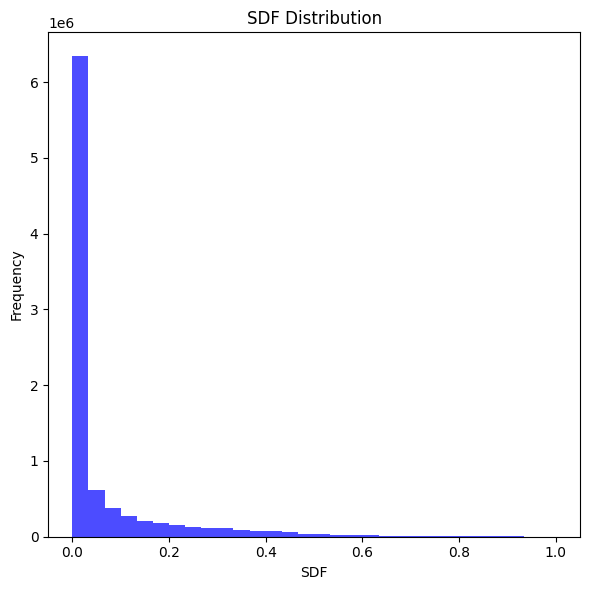

In [42]:
plot_sdf_distribution(sdf_vals)

### Velocity Magnitude Frequency

In [43]:
def plot_velocity_magnitude_distribution(velocity_magnitude: np.ndarray):
    """
    Plots a histogram for the velocity magnitude distribution.

    Parameters:
    velocity_magnitude: Array of velocity magnitude values.
    """
    plt.figure(figsize=(6, 6))
    plt.hist(velocity_magnitude, bins=30, color='green', alpha=0.7)
    plt.title("Airspeed Velocity Magnitude Distribution")
    plt.xlabel("Airspeed Velocity Magnitude")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

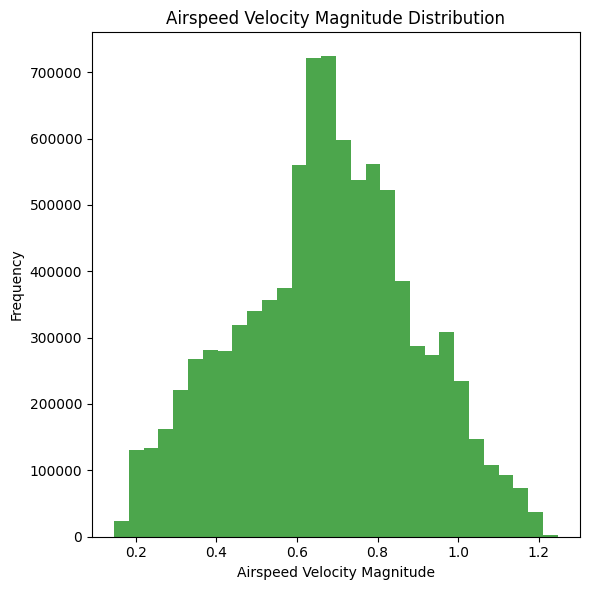

In [44]:
plot_velocity_magnitude_distribution(velocity_magnitude)

### Velocity to SDF Relationship

As seen in the airfoils in the data preparation script, air speed is highest and lowest at the front and back of the airfoil.

In [45]:
def plot_velocity_vs_sdf(
    sdf_vals: np.ndarray,
    v_x_vals: np.ndarray,
    v_y_vals: np.ndarray):
    """
    Plots a scatter plot of velocity magnitude vs. SDF.

    Parameters:
    sdf_vals: Array of SDF values.
    v_x_vals: Array of velocity x-components.
    v_y_vals: Array of velocity y-components.
    """

    # calculate velocity vector magnitude
    velocity_magnitude = np.sqrt(v_x_vals**2 + v_y_vals**2)

    # create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(sdf_vals, velocity_magnitude, alpha=0.5, color='blue')
    plt.title("Velocity Magnitude vs. SDF")
    plt.xlabel("SDF (Distance from Airfoil)")
    plt.ylabel("Velocity Magnitude")
    plt.show()

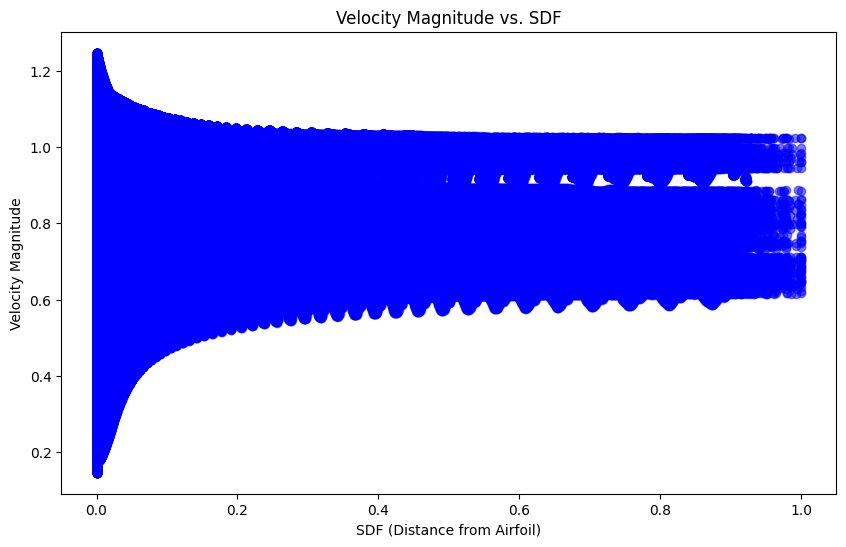

In [46]:
plot_velocity_vs_sdf(sdf_vals, v_x_vals, v_y_vals)

The relationship between velocity and SDF averaged out over each simulation can be seen here.

In [47]:
def plot_average_correlation_heatmaps(tensor_list):
    """
    Computes and plots average correlation heatmaps between sdf and (v_x, v_y),
    and sdf with the velocity magnitude across all tensors in the list.
    """
    total_corr_x = total_corr_y = total_corr_mag = np.zeros((2, 2))
    num_tensors = len(tensor_list)

    for tensor_data in tensor_list:
        data = tensor_data.numpy()
        sdf, v_x, v_y = data[:, 2], data[:, 3], data[:, 4]
        v_mag = np.sqrt(v_x**2 + v_y**2)

        total_corr_x += np.corrcoef(np.vstack((sdf, v_x)).T, rowvar=False)
        total_corr_y += np.corrcoef(np.vstack((sdf, v_y)).T, rowvar=False)
        total_corr_mag += np.corrcoef(np.vstack((sdf, v_mag)).T, rowvar=False)

    avg_corr_x, avg_corr_y, avg_corr_mag = total_corr_x / num_tensors, total_corr_y / num_tensors, total_corr_mag / num_tensors

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sns.heatmap(avg_corr_x, annot=True, cmap="coolwarm", fmt=".2f", ax=axs[0], xticklabels=["sdf", "v_x"], yticklabels=["sdf", "v_x"])
    sns.heatmap(avg_corr_y, annot=True, cmap="coolwarm", fmt=".2f", ax=axs[1], xticklabels=["sdf", "v_y"], yticklabels=["sdf", "v_y"])
    sns.heatmap(avg_corr_mag, annot=True, cmap="coolwarm", fmt=".2f", ax=axs[2], xticklabels=["sdf", "|v|"], yticklabels=["sdf", "|v|"])

    axs[0].set_title("Average Correlation: sdf and v_x")
    axs[1].set_title("Average Correlation: sdf and v_y")
    axs[2].set_title("Average Correlation: sdf and |v| (magnitude)")
    plt.tight_layout()
    plt.show()

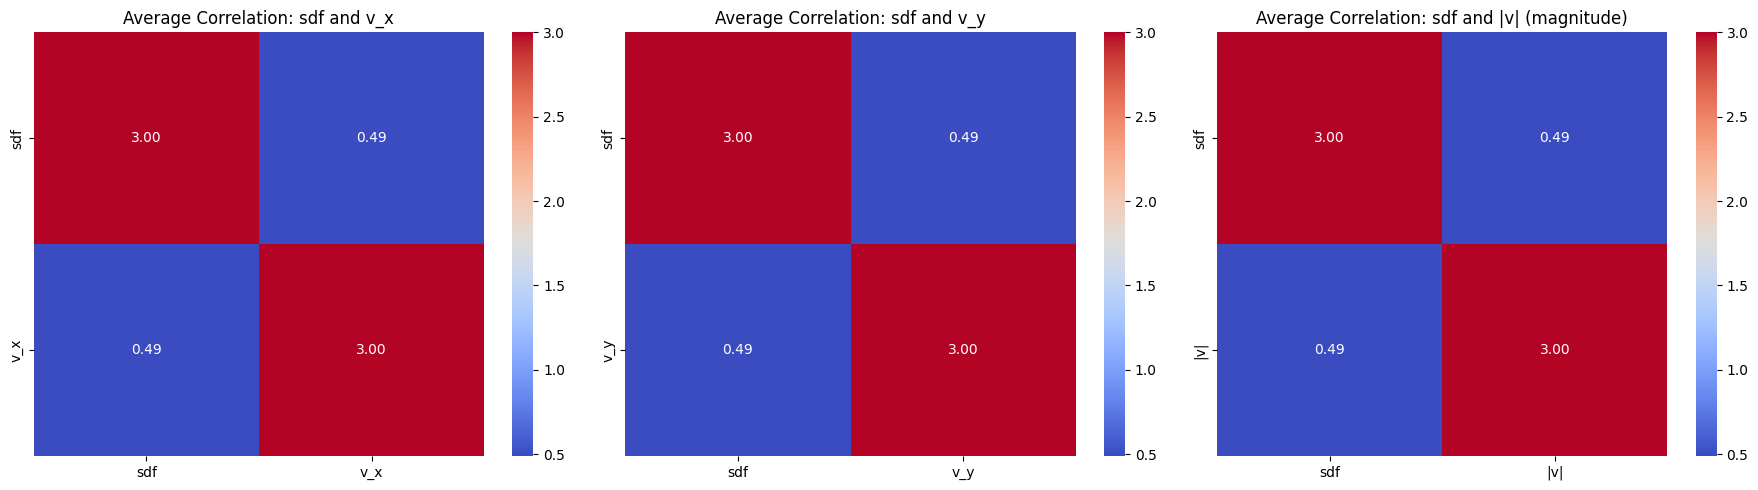

In [48]:
plot_average_correlation_heatmaps(tensor_data)